In [ ]:
# translator.py

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, val_loader, tokenizer):
    val_predictions, val_references = generate_predictions(model, val_loader, tokenizer)
    bleu_score = corpus_bleu(val_references, val_predictions)
    print("BLEU Score:", bleu_score)

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training and validation sets
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model
    evaluate_model(model, val_loader, tokenizer)

if __name__ == "__main__":
    main()


Epoch 1/10, Loss: 0.04265119731426239
Epoch 2/10, Loss: 0.039723163843154906
Epoch 3/10, Loss: 0.03745964020490646
Epoch 4/10, Loss: 0.03711083270609379
Epoch 5/10, Loss: 0.03712892457842827
Epoch 6/10, Loss: 0.03690508287400007
Epoch 7/10, Loss: 0.03621773030608892
Epoch 8/10, Loss: 0.03524652011692524
Epoch 9/10, Loss: 0.03194993156939745
Epoch 10/10, Loss: 0.028943407535552978
BLEU Score: 0.9972197287967844


In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, val_loader, tokenizer):
    val_predictions, val_references = generate_predictions(model, val_loader, tokenizer)
    bleu_score = corpus_bleu(val_references, val_predictions)
    accuracy = calculate_accuracy(val_predictions, val_references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training and validation sets
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model
    evaluate_model(model, val_loader, tokenizer)

if __name__ == "__main__":
    main()


Epoch 1/10, Loss: 0.03997589144855738
Epoch 2/10, Loss: 0.0377868615090847
Epoch 3/10, Loss: 0.03676415700465441
Epoch 4/10, Loss: 0.03626953791826963
Epoch 5/10, Loss: 0.03364861514419317
Epoch 6/10, Loss: 0.03000399600714445
Epoch 7/10, Loss: 0.02879620585590601
Epoch 8/10, Loss: 0.027911547943949698
Epoch 9/10, Loss: 0.028283362835645677
Epoch 10/10, Loss: 0.027464145235717295
BLEU Score: 0.9972279668079018
Accuracy: 0.0


In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Define a function to calculate data distribution
def calculate_data_distribution(target_texts):
    class_distribution = Counter(target_texts)
    total_samples = len(target_texts)
    print("Class Distribution:")
    for target_text, count in class_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"Target Text: {target_text}, Count: {count}, Percentage: {percentage:.2f}%")

# Define a function to evaluate the model
def evaluate_model(model, val_loader, tokenizer):
    val_predictions, val_references = generate_predictions(model, val_loader, tokenizer)
    bleu_score = corpus_bleu(val_references, val_predictions)
    accuracy = calculate_accuracy(val_predictions, val_references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)
    calculate_data_distribution([ref[0] for ref in val_references])

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Calculate data distribution
    calculate_data_distribution(target_texts)

    # Split the dataset into training and validation sets
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model
    evaluate_model(model, val_loader, tokenizer)

if __name__ == "__main__":
    main()


Class Distribution:
Target Text: يهدر, Count: 2, Percentage: 0.51%
Target Text: واش الدعوة, Count: 2, Percentage: 0.51%
Target Text: الهدرة, Count: 2, Percentage: 0.51%
Target Text: وقتاش, Count: 3, Percentage: 0.77%
Target Text: واحد الخطرة, Count: 1, Percentage: 0.26%
Target Text: ما كالاه, Count: 1, Percentage: 0.26%
Target Text: واش بيك, Count: 2, Percentage: 0.51%
Target Text: درت, Count: 3, Percentage: 0.77%
Target Text: طاح, Count: 1, Percentage: 0.26%
Target Text: زعاف, Count: 1, Percentage: 0.26%
Target Text: باهي, Count: 1, Percentage: 0.26%
Target Text: ياسر, Count: 1, Percentage: 0.26%
Target Text: نسقي, Count: 1, Percentage: 0.26%
Target Text: هنايا, Count: 2, Percentage: 0.51%
Target Text: بركا, Count: 2, Percentage: 0.51%
Target Text: البوسطة, Count: 2, Percentage: 0.51%
Target Text: البلاصة, Count: 2, Percentage: 0.51%
Target Text: باش, Count: 3, Percentage: 0.77%
Target Text: واش تخدم, Count: 2, Percentage: 0.51%
Target Text: طوموبيل, Count: 2, Percentage: 0.51%
Target

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, data_loader, tokenizer):
    predictions, references = generate_predictions(model, data_loader, tokenizer)
    bleu_score = corpus_bleu(references, predictions)
    accuracy = calculate_accuracy(predictions, references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader, tokenizer)

if __name__ == "__main__":
    main()


Epoch 1/10, Loss: 0.03104998804628849
Epoch 2/10, Loss: 0.02930828221142292
Epoch 3/10, Loss: 0.029138502851128577
Epoch 4/10, Loss: 0.029076411947607995
Epoch 5/10, Loss: 0.02906528376042843
Epoch 6/10, Loss: 0.028335828706622122
Epoch 7/10, Loss: 0.02632415257394314
Epoch 8/10, Loss: 0.025057995319366456
Epoch 9/10, Loss: 0.02499835640192032
Epoch 10/10, Loss: 0.024220496788620947
BLEU Score: 0.9968346406622987
Accuracy: 0.0


In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
import re

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
            tokenized_text = tokenized_text[:512]  # Truncate if longer than max length
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_seq_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        input_ids = input_tokenized['input_ids'].flatten()[:self.max_seq_length]
        target_ids = target_tokenized['input_ids'].flatten()[:self.max_seq_length]

        input_mask = input_tokenized['attention_mask'].flatten()[:self.max_seq_length]
        target_mask = target_tokenized['attention_mask'].flatten()[:self.max_seq_length]

        return {
            'input_ids': input_ids,
            'attention_mask': input_mask,
            'labels': target_ids
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, val_loader, tokenizer):
    val_predictions, val_references = generate_predictions(model, val_loader, tokenizer)
    bleu_score = corpus_bleu(val_references, val_predictions)
    accuracy = calculate_accuracy(val_predictions, val_references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Clean Arabic text
    input_texts = [clean_arabic_text(text) for text in input_texts]
    target_texts = [clean_arabic_text(text) for text in target_texts]

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model
    print("Evaluation on Validation Data:")
    evaluate_model(model, val_loader, tokenizer)

    # Evaluate the model on test data
    print("\nEvaluation on Test Data:")
    evaluate_model(model, test_loader, tokenizer)

# Function to clean Arabic text
def clean_arabic_text(text):
    # Remove non-Arabic characters and digits
    cleaned_text = re.sub(r'[^؀-ۿ]+', ' ', text)
    return cleaned_text

if __name__ == "__main__":
    main()


Epoch 1/10, Loss: 0.03717531147412956
Epoch 2/10, Loss: 0.034057453158311546
Epoch 3/10, Loss: 0.03331532119773328
Epoch 4/10, Loss: 0.032662784680724144
Epoch 5/10, Loss: 0.03017597331199795
Epoch 6/10, Loss: 0.0302405774127692
Epoch 7/10, Loss: 0.027968872571364045
Epoch 8/10, Loss: 0.02662086416967213
Epoch 9/10, Loss: 0.026422158582136035
Epoch 10/10, Loss: 0.026217392180114985
Evaluation on Validation Data:
BLEU Score: 0.9975209603045636
Accuracy: 0.0

Evaluation on Test Data:
BLEU Score: 0.9959310569362108
Accuracy: 0.0


Epoch 1/10, Loss: 0.032190154492855075
Epoch 2/10, Loss: 0.029773498326539992
Epoch 3/10, Loss: 0.02928152456879616
Epoch 4/10, Loss: 0.02926597148180008
Epoch 5/10, Loss: 0.02875470407307148
Epoch 6/10, Loss: 0.028498687967658042
Epoch 7/10, Loss: 0.026150428131222724
Epoch 8/10, Loss: 0.0252027478069067
Epoch 9/10, Loss: 0.0244285948574543
Epoch 10/10, Loss: 0.02721574418246746


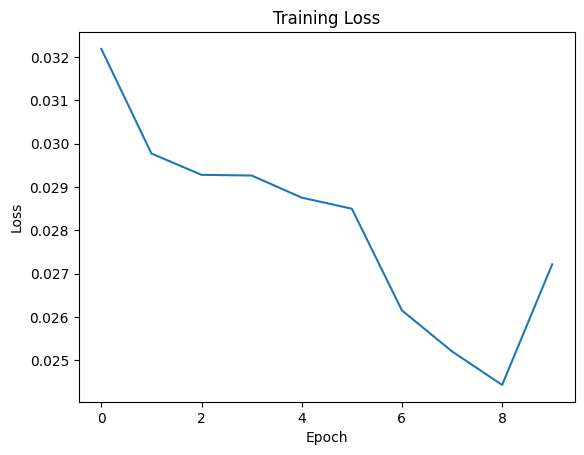

BLEU Score: 0.9967331678491029
Accuracy: 0.0


In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}")
        losses.append(val_loss)

    # Plot the loss over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, data_loader, tokenizer):
    predictions, references = generate_predictions(model, data_loader, tokenizer)
    bleu_score = corpus_bleu(references, predictions)
    accuracy = calculate_accuracy(predictions, references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader, tokenizer)

if __name__ == "__main__":
    main()


Epoch 1/10, Train Loss: 1.015502342166236, Val Loss: 0.03766741901636124
Epoch 2/10, Train Loss: 0.044243129495626844, Val Loss: 0.030654311180114746
Epoch 3/10, Train Loss: 0.040745427330526024, Val Loss: 0.030078255757689475
Epoch 4/10, Train Loss: 0.03929223440205439, Val Loss: 0.030144232511520385
Epoch 5/10, Train Loss: 0.03851719773732699, Val Loss: 0.030402509868144988
Epoch 6/10, Train Loss: 0.038066608138764516, Val Loss: 0.03022633455693722
Epoch 7/10, Train Loss: 0.03764910057473641, Val Loss: 0.03017663545906544
Epoch 8/10, Train Loss: 0.0372203591112525, Val Loss: 0.0298834428191185
Epoch 9/10, Train Loss: 0.03656142202611917, Val Loss: 0.02935061603784561
Epoch 10/10, Train Loss: 0.035594641541441284, Val Loss: 0.028746987879276275
BLEU Score: 0.9969180502661564
Accuracy: 0.0


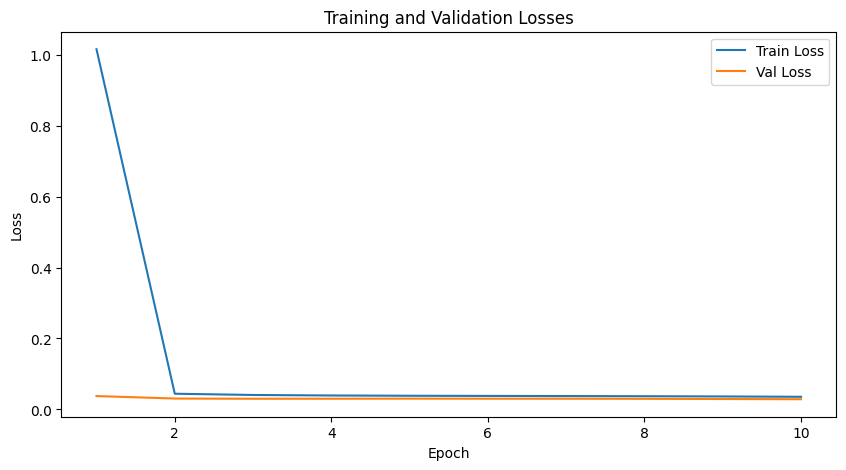

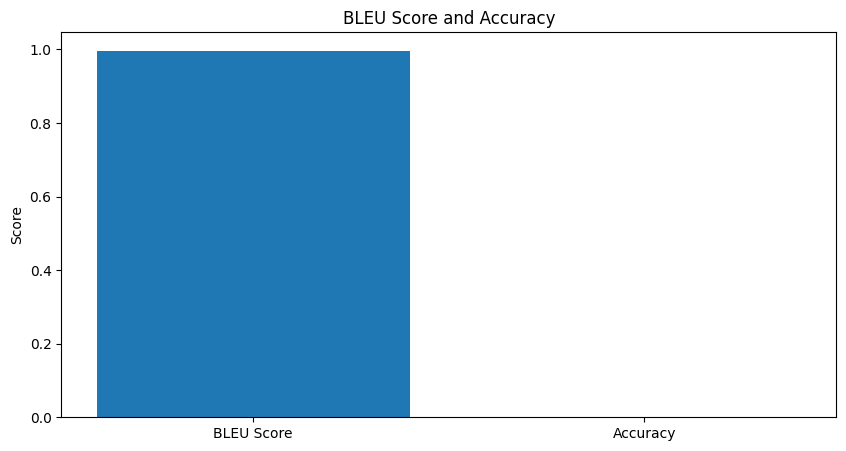

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

# Define the Seq2Seq model class
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, input_seq, target_seq):
        embedded_input = self.embedding(input_seq)
        encoder_output, (encoder_hidden, encoder_cell) = self.encoder(embedded_input)

        # Initialize decoder hidden and cell states based on encoder output
        decoder_hidden = encoder_hidden  # Ensure decoder initial hidden state matches encoder final hidden state
        decoder_cell = encoder_cell  # Ensure decoder initial cell state matches encoder final cell state

        # Ensure the size of the input tensor passed to the decoder LSTM matches the expected input size
        if target_seq.size(-1) != self.embedding.embedding_dim:
            target_seq = target_seq.long()  # Convert to LongTensor
            target_seq = self.embedding(target_seq)

        decoder_output, _ = self.decoder(target_seq, (decoder_hidden, decoder_cell))
        output = self.output_layer(decoder_output.squeeze(0))  # Remove batch dimension
        return output

# Define the custom tokenizer class
class CustomTokenizer:
    def __init__(self, texts):
        self.vocab = Counter(' '.join(texts).split())
        self.vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[EOS]'] + sorted(self.vocab, key=self.vocab.get, reverse=True)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __call__(self, text, padding=False, truncation=False, return_tensors='pt'):
        tokenized_text = [self.word2idx.get(word, 1) for word in text.split()]
        if padding:
            max_length = max(len(tokenized_text), 512)
            tokenized_text += [0] * (max_length - len(tokenized_text))
        return {
            'input_ids': torch.tensor(tokenized_text).unsqueeze(0),
            'attention_mask': torch.ones(len(tokenized_text)).unsqueeze(0)
        }

# Define the translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_tokenized = self.tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer(target_text, padding=True, truncation=True, return_tensors='pt')

        return {
            'input_ids': input_tokenized['input_ids'].flatten(),
            'attention_mask': input_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }

# Define the function to train the model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            loss = criterion(output.permute(0, 2, 1), labels)  # Permute to match CrossEntropyLoss input format
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                input_ids = batch['input_ids']
                labels = batch['labels']
                output = model(input_ids, labels)
                val_loss += criterion(output.permute(0, 2, 1), labels).item()  # Permute to match CrossEntropyLoss input format
            val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss / len(train_loader)}, Val Loss: {val_loss}")
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss)

    return train_losses, val_losses

# Define the function to generate predictions
def generate_predictions(model, data_loader, tokenizer):
    predictions = []
    references = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            output = model(input_ids, labels)
            predicted_ids = output.argmax(dim=-1)
            for predicted_seq, target_seq in zip(predicted_ids, labels):
                predicted_seq = predicted_seq.tolist()
                target_seq = target_seq.tolist()
                # Convert token IDs to text
                predicted_text = ' '.join([tokenizer.idx2word[token_id] for token_id in predicted_seq])
                target_text = ' '.join([tokenizer.idx2word[token_id] for token_id in target_seq])
                predictions.append(predicted_text)
                references.append([target_text])  # References should be a list of lists for each sequence

    return predictions, references

# Define a function to evaluate the model
def evaluate_model(model, data_loader, tokenizer):
    predictions, references = generate_predictions(model, data_loader, tokenizer)
    bleu_score = corpus_bleu(references, predictions)
    accuracy = calculate_accuracy(predictions, references)
    print("BLEU Score:", bleu_score)
    print("Accuracy:", accuracy)
    return bleu_score, accuracy

# Define a function to calculate accuracy
def calculate_accuracy(predictions, references):
    correct = 0
    total = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Main function for training and evaluation
def main():
    # Load the dataset from CSV file
    df = pd.read_csv("Paralleld.csv")

    # Extract input texts and target texts from the DataFrame
    input_texts = df["Algerian_Dialect"].astype(str).tolist()
    target_texts = df["Literary_Arabic"].astype(str).tolist()

    # Preprocess the dataset
    tokenizer = CustomTokenizer(input_texts + target_texts)
    dataset = TranslationDataset(input_texts, target_texts, tokenizer)

    # Split the dataset into training, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Define hyperparameters
    input_vocab_size = len(tokenizer.vocab)
    target_vocab_size = len(tokenizer.vocab)
    embedding_dim = 128
    hidden_dim = 256
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = Seq2SeqModel(input_vocab_size, target_vocab_size, embedding_dim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, val_losses = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)

    # Evaluate the model on the test set
    bleu_score, accuracy = evaluate_model(model, test_loader, tokenizer)

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plot the BLEU score and accuracy
    plt.figure(figsize=(10, 5))
    plt.bar(['BLEU Score', 'Accuracy'], [bleu_score, accuracy])
    plt.ylabel('Score')
    plt.title('BLEU Score and Accuracy')
    plt.show()

if __name__ == "__main__":
    main()
